In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from coherenceModel import *
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [2]:
paragraph_df = pd.read_csv('aviationPerms.csv')
paragraph_df

,paragraph,is_coherent
0,The preflight inspection of the fuel tanks by ...,1
1,"The pilot reported that he was cleared to 4,00...",1
2,The instrument-rated private pilot lost contro...,1
3,The non-instrument rated private pilot was rec...,1
4,The commercial pilot reported a partial power ...,1
...,...,...
2095,THE FUEL SELECTOR WAS POSITIONED ON THE RIGHT ...,0
2096,DURING AN INTENTIONAL MANEUVER TO AVOID A HOME...,0
2097,RESIDUAL FUEL WAS FOUND IN THE CARBURETOR BOWL...,0
2098,"AT A 75% POWER SETTING, FUEL FLOW IS ABOUT 10....",0


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    paragraph_df.paragraph.values, 
    paragraph_df.is_coherent.values,
    stratify = paragraph_df.is_coherent.values,
    test_size = 0.1, 
    random_state = 487
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    stratify = y_train,
    test_size = 0.2, 
    random_state = 487
)
print(X_train[0])
print(y_train[0])

Routine air work was performed and then touch-and-go landing practice was planned. The approach and landing on runway 34 was normal. During the takeoff roll the pilot noticed that unusual stick forces were required to raise the tail wheel. FAA inspectors examined the airplane and did not report finding any trim or control system irregularity; however, the fuselage distortion precluded a complete examination. He saw a row of sailplanes parked on runway 30 in his path and elected to turn off the runway into sagebrush and grass. He decided to abort the takeoff and applied forward stick to prevent the airplane from leaping off the runway in a stalled condition. The trim setting was rechecked and confirmed. The pilot added some additional nose down trim, but no relief of stick pressure was noticed. He was drifting to the right and approaching the intersection of runway 30 at this time. The right main landing gear fell into a ditch and collapsed, buckling and distorting the fuselage. Trim wa

In [4]:
embed = KeyedVectors.load('vectors.kv')

In [5]:
train_data = WindowedParDataset(X_train, y_train, embed, 3)
dev_data = WindowedParDataset(X_val, y_val, embed, 3)
test_data = WindowedParDataset(X_test, y_test, embed, 3)

In [6]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=basic_collate_fn, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 104-- batch loss = 0.1733
Validation accuracy: 0.5000
Validation loss: 0.1895
Epoch No. 2--Iteration No. 208-- batch loss = 0.1480
Validation accuracy: 0.5000
Validation loss: 0.1841
Epoch No. 3--Iteration No. 312-- batch loss = 0.0302
Validation accuracy: 0.5000
Validation loss: 0.1690
Epoch No. 4--Iteration No. 416-- batch loss = 0.3569
Validation accuracy: 0.5000
Validation loss: 0.1590
Epoch No. 5--Iteration No. 520-- batch loss = 0.0619
Validation accuracy: 0.5000
Validation loss: 0.1545
Epoch No. 6--Iteration No. 624-- batch loss = 0.1616
Validation accuracy: 0.5000
Validation loss: 0.1569
Epoch No. 7--Iteration No. 728-- batch loss = 0.2314
Validation accuracy: 0.5000
Validation loss: 0.1541
Epoch No. 8--Iteration No. 832-- batch loss = 0.2515
Validation accuracy: 0.5000
Validation loss: 0.1441
Epoch No. 9--Iteration No. 936-- batch loss = 0.1807
Validation accuracy: 0.5000
Validation los

Validation accuracy: 0.8980
Validation loss: 0.0252
Epoch No. 78--Iteration No. 8112-- batch loss = 0.0414
Validation accuracy: 0.9009
Validation loss: 0.0259
Epoch No. 79--Iteration No. 8216-- batch loss = 0.0050
Validation accuracy: 0.8447
Validation loss: 0.0580
Epoch No. 80--Iteration No. 8320-- batch loss = 0.1402
Validation accuracy: 0.7976
Validation loss: 0.0650
Epoch No. 81--Iteration No. 8424-- batch loss = 0.0912
Validation accuracy: 0.8663
Validation loss: 0.0389
Epoch No. 82--Iteration No. 8528-- batch loss = 0.1134
Validation accuracy: 0.8998
Validation loss: 0.0393
Epoch No. 83--Iteration No. 8632-- batch loss = 0.0028
Validation accuracy: 0.8978
Validation loss: 0.0299
Epoch No. 84--Iteration No. 8736-- batch loss = 0.0029
Validation accuracy: 0.9122
Validation loss: 0.0344
Epoch No. 85--Iteration No. 8840-- batch loss = 0.0032
Validation accuracy: 0.9100
Validation loss: 0.0243
Epoch No. 86--Iteration No. 8944-- batch loss = 0.0030
Validation accuracy: 0.9012
Validatio

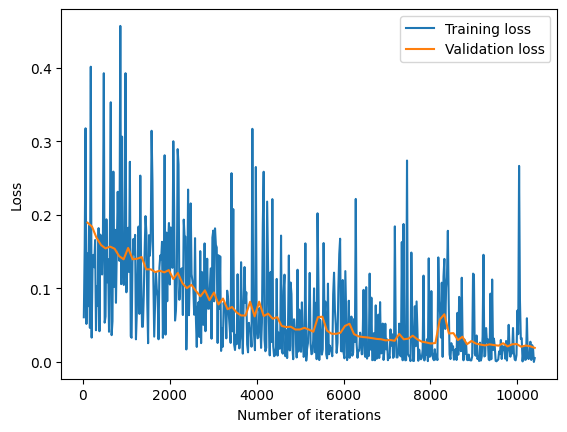

In [40]:
# test on validation to see if overfit is possible
ffnn = FFNN(200, 200, False, 3, device)
ffnn.to(device)
optim = get_optimizer(ffnn, lr=1e-3, weight_decay=0)
best_model, stats = train_model(ffnn, dev_loader, dev_loader, optim,
                                num_epoch=100, collect_cycle=20, device=device, patience=None)
plot_loss(stats)

In [8]:
import itertools
from tqdm.notebook import tqdm

def search_param_utterance():
    """Experiemnt on different hyper parameters."""
    hidden_dim, learning_rate, weight_decay, window_sizes = get_hyper_parameters()
    print("hidden dimension from: {}\nlearning rate from: {}\nweight_decay from: {}\nwindow from: {}".format(
        hidden_dim, learning_rate, weight_decay, window_sizes
    ))
    best_model, best_stats = None, None
    best_accuracy, best_lr, best_wd, best_hd, best_window_size = 0, 0, 0, 0, 0
    for hd, lr, wd, window_size in tqdm(itertools.product(hidden_dim, learning_rate, weight_decay, window_sizes),
                           total=len(hidden_dim) * len(learning_rate) * len(weight_decay) * len(window_sizes)):
        net = FFNN(hd, 200, True, window_size, device).to(device)
        optim = get_optimizer(net, lr=lr, weight_decay=wd)
        model, stats = train_model(net, train_loader, dev_loader, optim, num_epoch=100,
                                   collect_cycle=500, device=device, verbose=True, patience=15)
        # print accuracy
        print(f"{(hd, lr, wd, window_size)}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_hd, best_lr, best_wd, best_window_size = hd, lr, wd, window_size
            torch.save(best_model.state_dict(), 'best_rnn.pt')
    print("\n\nBest hidden dimension: {}, Best learning rate: {}, best weight_decay: {}, best window: {}".format(
        best_hd, best_lr, best_wd, best_window_size))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model
basic_model = search_param_utterance()

hidden dimension from: [1200]
learning rate from: [0.003, 0.0003]
weight_decay from: [1.0, 1.25, 2.5]
window from: [3, 5, 7]


  0%|          | 0/18 [00:00<?, ?it/s]

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 392-- batch loss = 0.5885
Validation accuracy: 0.5000
Validation loss: 0.5457
Epoch No. 2--Iteration No. 784-- batch loss = 0.5600
Validation accuracy: 0.5000
Validation loss: 0.5480


KeyboardInterrupt: 